In [1]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import time

## load data

In [2]:
# load training data
filename = []
label = []
with open('train.txt', 'r') as f:
    for line in f.readlines():
        s = line.split(' ')
        filename.append(s[0])
        label.append(int(s[1]))
print(len(label))

63325


In [3]:
dataset_train = []
for i in range(len(filename)):
    dataset_train.append((filename[i],label[i]))

In [4]:
# load testing data
filename_test = []
label_test = []
with open('test.txt', 'r') as f:
    for line in f.readlines():
        s = line.split(' ')
        filename_test.append(s[0])
        label_test.append(int(s[1]))
print(len(label_test))

450


In [5]:
dataset_test = []
for i in range(len(filename_test)):
    dataset_test.append((filename_test[i],label_test[i]))

In [6]:
# load validation data
filename_val = []
label_val = []
with open('val.txt', 'r') as f:
    for line in f.readlines():
        s = line.split(' ')
        filename_val.append(s[0])
        label_val.append(int(s[1]))
print(len(label_val))

450


In [7]:
dataset_val = []
for i in range(len(filename_val)):
    dataset_val.append((filename_val[i],label_val[i]))

In [9]:
image_paths_train, y_train = zip(*dataset_train[::20])
image_paths_test, y_test = zip(*dataset_test)
image_paths_val, y_val = zip(*dataset_val)

# Feature Extraction using ORB

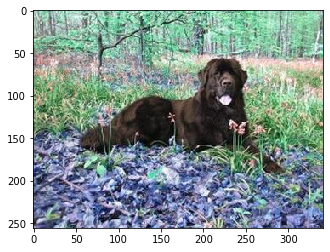

In [10]:
# 初始化ORB特征检测器对象 (chatgpt)
orb = cv2.ORB_create(nfeatures=500, scaleFactor=1.2, nlevels=8, edgeThreshold=15)
im=cv2.imread(image_paths_train[1])
plt.imshow(im)

## Function for plotting keypoints

In [11]:
def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    for kp in keypoints:
            x, y = kp.pt
            plt.imshow(cv2.circle(vis, (int(x), int(y)), 2, color))

## Plotting the keypoints

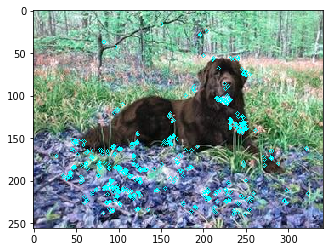

In [12]:
kp, des = orb.detectAndCompute(im, None)
img=draw_keypoints(im,kp)

# Appending descriptors of the training images in list

In [13]:
import cv2
import multiprocessing

def process_image(image_path):
    im=cv2.imread(image_path)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    blur = cv2.GaussianBlur(equalized, (5, 5), 0)
    keypoints, descriptor = orb.detectAndCompute(blur, None)
    return (image_path, descriptor)

if __name__ == '__main__':
    des_list = []
    num_processes = 16 # 設定使用的進程數量，可以根據電腦配置調整
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_image, image_paths_train)
    des_list = results

In [14]:
print(len(des_list[0][1]))

500


In [15]:
descriptors=des_list[0][1]
descriptors = np.concatenate([descriptor for _, descriptor in des_list[1:]], axis=0)
descriptors_float=np.array(descriptors).astype(float)

# Performing K Means clustering on Descriptors

In [16]:
from scipy.cluster.vq import kmeans,vq
from sklearn.cluster import MiniBatchKMeans

In [17]:
# chatgpt 
k = 500
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=512, max_iter=1200).fit(descriptors_float)
voc = kmeans.cluster_centers_
variance = kmeans.inertia_

#### Creating histogram of training image

In [18]:
im_features=np.zeros((len(des_list),k),"float32")
for i in range(len(des_list)):
    words, _ = vq(des_list[i][1], voc)

    # 使用bincount函数计算单个图像中每个单词出现的次数，并将结果存储到im_features数组中
    im_features[i] = np.bincount(words, minlength=k)

### Applying standardisation on training feature

In [19]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

### Create testing image feature 

In [20]:
if __name__ == '__main__':
    des_list_test = []
    num_processes = 16 # 設定使用的進程數量，可以根據電腦配置調整
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_image, image_paths_test)
    des_list_test = results

In [21]:
im_features_test=np.zeros((len(des_list_test),k),"float32")
for i in range(len(des_list_test)):
    words, _ = vq(des_list_test[i][1], voc)

    # 使用bincount函数计算单个图像中每个单词出现的次数，并将结果存储到im_features数组中
    im_features_test[i] = np.bincount(words, minlength=k)
im_features_test=stdslr.transform(im_features_test)

### Create validation image feature 

In [22]:
if __name__ == '__main__':
    des_list_val = []
    num_processes = 16 # 設定使用的進程數量，可以根據電腦配置調整
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_image, image_paths_val)
    des_list_val = results

In [23]:
im_features_val=np.zeros((len(des_list_val),k),"float32")
for i in range(len(des_list_val)):
    words, _ = vq(des_list_val[i][1], voc)

    # 使用bincount函数计算单个图像中每个单词出现的次数，并将结果存储到im_features数组中
    im_features_val[i] = np.bincount(words, minlength=k)
im_features_val=stdslr.transform(im_features_val)

# Computational Graph Training

In [24]:
class MultiplyGate:
    def forward(self,W, X):
        return np.dot(X, W)

    def backward(self, W, X, dZ):
        dW = np.dot(np.transpose(X), dZ)
        dX = np.dot(dZ, np.transpose(W))
        return dW, dX

class AddGate:
    def forward(self, X, b):
        return X + b

    def backward(self, X, b, dZ):
        dX = dZ * np.ones_like(X)
        db = np.dot(np.ones((1, dZ.shape[0]), dtype=np.float64), dZ)
        return db, dX

In [25]:
# class Sigmoid:
#     def forward(self, X):
#         return 1.0 / (1.0 + np.exp(-X))

#     def backward(self, X, top_diff):
#         output = self.forward(X)
#         return (1.0 - output) * output * top_diff

class Tanh:
    def forward(self, X):
        return np.tanh(X)

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - np.square(output)) * top_diff

In [41]:
class Sigmoid():
    def forward(self, X):
        return X * self._sigmoid(X)

    def backward(self, X, dout):
        dX = dout * self._sigmoid(X) * (1 - self._sigmoid(X))
        return dX

    def _sigmoid(self, X):
        # Clip the input values between -500 and 500
        X = np.clip(X, -500, 500)
        return 1 / (1 + np.exp(-X+1e-10))

In [27]:
class SigmoidMSE:
    def predict(self, X):
        return 1./ (1.0 + np.exp(-X))

    def loss(self, X, y):
        y_hat = self.predict(X)
        data_loss = 0.5*(y_hat - y)**2
        return data_loss

    def diff(self, X, y):
        y_hat = self.predict(X)
        return (y_hat - y) * y_hat * (1 - y_hat)

In [28]:
class SiluMSE:
    def predict(self, X):
        return X / (1.0 + np.exp(-X))
    def loss(self, X, y):
        y_hat = self.predict(X)
        data_loss = 0.5*(y_hat - y)**2
        return data_loss

    def diff(self, X, y):
        y_hat = self.predict(X)
        return (y_hat - y) * (1 + np.exp(-X) + X*np.exp(-X)) / (1 + np.exp(-X))**2

In [29]:
class CrossEntropy:
    def predict(self, X):
        X -= np.max(X, axis=1, keepdims=True)  # Add scaling here
        exp_scores = np.exp(X - np.max(X, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def loss(self, X, y):
        num_examples = len(X)
        probs = self.predict(X)
        corect_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(corect_logprobs)
        return 1./num_examples * data_loss

    def diff(self, X, y):
        num_examples = len(X)
        probs = self.predict(X)
        probs[range(num_examples),y] -= 1
        return probs

In [30]:
class Softmax:
    def predict(self, X):
        X -= np.max(X, axis=1, keepdims=True)  # Add scaling here
        exp_scores = np.exp(X)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def loss(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        corect_logprobs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(corect_logprobs)
        return 1./num_examples * data_loss

    def diff(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        probs[range(num_examples), y] -= 1
        return probs

In [31]:
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_std = (X - mean) / (std+1e-9)
    return X_std

# Backpropagation Model

In [96]:
class Model:
    def __init__(self, layers_dim):
        self.b = []
        self.W = []
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i]))
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

    def calculate_loss(self, X, y):
        
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Sigmoid()
        softmaxOutput = Softmax()

        # input = X
        input = standardize(X)
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        return np.mean(softmaxOutput.loss(input, y))

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Sigmoid()
        softmaxOutput = Softmax()

        # input = X
        input = standardize(X)
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)           

        probs = softmaxOutput.predict(input)

        return probs

    def calculate_accuracy(self, X, y):
        predictions = np.argmax(self.predict(X), axis=1)
        return np.mean(predictions == y)
    
    def train(self, X, y, X_val, y_val, num_passes=20000, epsilon=0.01, reg_lambda=0.01, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Sigmoid()
        softmaxOutput = Softmax()
    
        # Create empty list to store loss values
        loss_values = []
        acc_values = []
        loss_values_val = []
        acc_values_val = []
        total_feature = len(X.T)
        for epoch in range(num_passes):
            # Forward propagation
            # input = X
            input = standardize(X)
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))
    
            # Back propagation
            dtanh = softmaxOutput.diff(forward[len(forward)-1][0], y.flatten()[:,None])
            # print(dtanh)
            for i in range(len(forward)-1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)
                # Add regularization terms (b1 and b2 don't have regularization terms)
                dW += reg_lambda * self.W[i-1]
                # Gradient descent parameter update
                self.b[i-1] += -epsilon * db
                self.W[i-1] += -epsilon * dW
    
            if print_loss and epoch % 1 == 0:
                # Calculate and store loss and accuracy values
                loss = self.calculate_loss(X, y)#/total_feature
                acc = self.calculate_accuracy(X, y)
                loss_values.append((epoch+1, loss))
                acc_values.append((epoch+1, acc))
                loss_val = self.calculate_loss(X_val, y_val)#/total_feature
                acc_val  = self.calculate_accuracy(X_val, y_val)
                loss_values_val.append((epoch+1, loss_val))
                acc_values_val.append((epoch+1, acc_val))
                print("Loss after iteration %i: %f" %(epoch, loss))
                print("Accuracy after iteration %i: %f" %(epoch, acc))
                print("Validation: %.4f, %.4f" %(loss_val, acc_val)) 
                print("--------------------------------------------")

        # Plot loss values using matplotlib
        if print_loss:
            epochs, losses = zip(*loss_values)
            _, losses_val = zip(*loss_values_val)
            f = plt.figure(figsize=(7,5), dpi=100)
            plt.plot(epochs, losses)
            plt.plot(epochs, losses_val)
            # plt.title('Training Loss')
            plt.legend(["training data", "validation data"], loc = "upper right")
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()

        # Plot accuracy values using matplotlib
            epochs, accuracies = zip(*acc_values)
            _, accuracies_val = zip(*acc_values_val)
            f = plt.figure(figsize=(7,5), dpi=100)
            plt.plot(epochs, accuracies)
            plt.plot(epochs, accuracies_val)
            plt.legend(["training data", "validation data"], loc = "lower right")
            # plt.title('Training Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.show()

# Load Data

In [58]:
# load training data
train_data = im_features
train_labels = np.array(y_train)
# load validtion data
val_data = im_features_val
val_labels = np.array(y_val)
# load testing data
test_data = im_features_test
test_labels = np.array(y_test)

In [59]:
print(train_data.shape)
print(train_labels.shape)

(3167, 500)
(3167,)


Loss after iteration 0: 4.566334
Accuracy after iteration 0: 0.018314
Validation: 4.5156, 0.0200
--------------------------------------------
Loss after iteration 1: 4.437172
Accuracy after iteration 1: 0.016419
Validation: 4.3973, 0.0200
--------------------------------------------
Loss after iteration 2: 4.282996
Accuracy after iteration 2: 0.018945
Validation: 4.2549, 0.0156
--------------------------------------------
Loss after iteration 3: 4.196168
Accuracy after iteration 3: 0.017682
Validation: 4.1689, 0.0178
--------------------------------------------
Loss after iteration 4: 4.148869
Accuracy after iteration 4: 0.016735
Validation: 4.1202, 0.0244
--------------------------------------------
Loss after iteration 5: 4.127405
Accuracy after iteration 5: 0.015788
Validation: 4.0993, 0.0267
--------------------------------------------
Loss after iteration 6: 4.115209
Accuracy after iteration 6: 0.017051
Validation: 4.0880, 0.0267
--------------------------------------------
Loss a

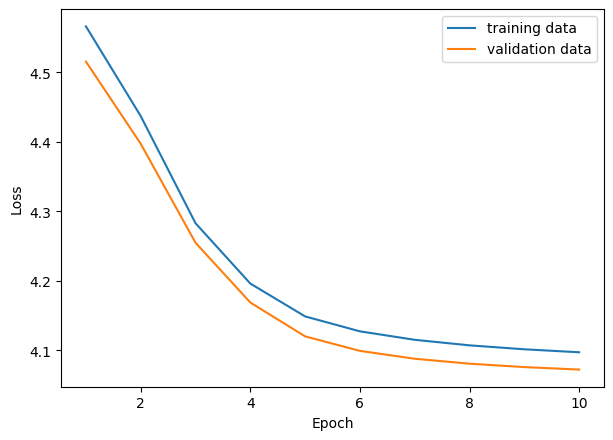

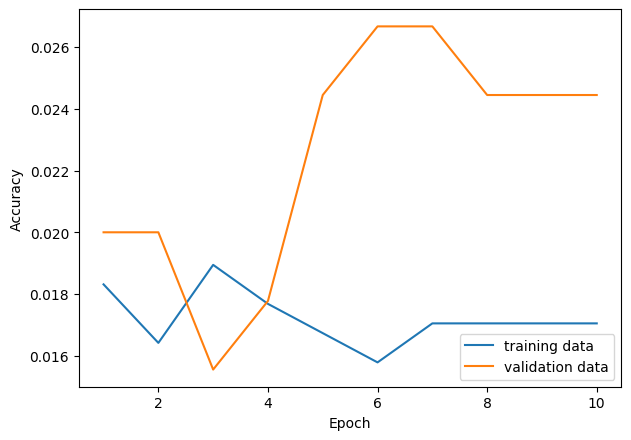

Total time used: 2.0582735538482666 sec


In [97]:
layers_dim = [500, 64, 50]
start_time = time.time()
model = Model(layers_dim)
model.train(train_data, train_labels, val_data, val_labels, num_passes=10, epsilon=0.0001, reg_lambda=0.0, print_loss=True)
print("Total time used:", time.time() - start_time, "sec")

In [98]:
acc_test = model.calculate_accuracy(test_data, test_labels)
print("Accuracy of Testing Data : %.4f" %(acc_test))

Accuracy of Testing Data : 0.0244


Loss after iteration 0: 4.472976
Accuracy after iteration 0: 0.018630
Validation: 4.4693, 0.0244
--------------------------------------------
Loss after iteration 1: 4.170589
Accuracy after iteration 1: 0.020208
Validation: 4.1664, 0.0244
--------------------------------------------
Loss after iteration 2: 4.019308
Accuracy after iteration 2: 0.020840
Validation: 4.0116, 0.0222
--------------------------------------------
Loss after iteration 3: 4.003534
Accuracy after iteration 3: 0.021156
Validation: 3.9952, 0.0244
--------------------------------------------
Loss after iteration 4: 3.999157
Accuracy after iteration 4: 0.020840
Validation: 3.9908, 0.0244
--------------------------------------------
Loss after iteration 5: 3.997102
Accuracy after iteration 5: 0.021787
Validation: 3.9887, 0.0244
--------------------------------------------
Loss after iteration 6: 3.996007
Accuracy after iteration 6: 0.021787
Validation: 3.9876, 0.0244
--------------------------------------------
Loss a

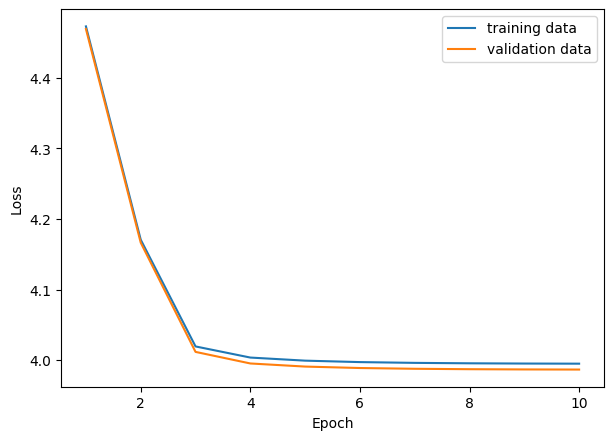

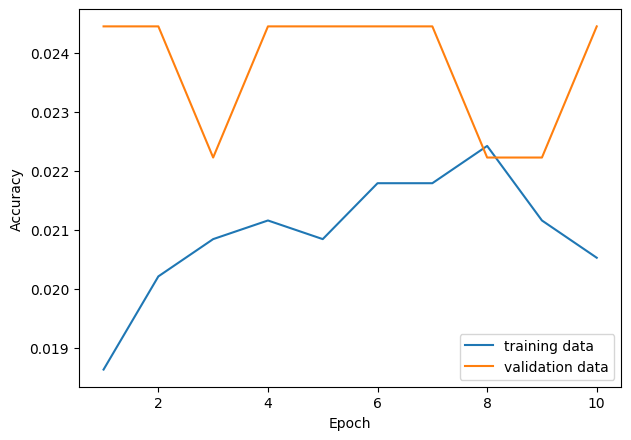

Total time used: 2.3133721351623535 sec


In [100]:
layers_dim = [500, 64, 64, 50]
start_time = time.time()
model = Model(layers_dim)
model.train(train_data, train_labels, val_data, val_labels, num_passes=10, epsilon=0.0001, reg_lambda=0.0, print_loss=True)
print("Total time used:", time.time() - start_time, "sec")

In [101]:
acc_test = model.calculate_accuracy(test_data, test_labels)
print("Accuracy of Testing Data : %.4f" %(acc_test))

Accuracy of Testing Data : 0.0333
